# Lecture 10 Locality Sensitive Hashing
__Math 3280: Data Mining__

__Outline__
1. LSH

__Reading__ 
* Leskovec, Sections 

## Locality-Sensitive Hashing for Documents

In [1]:
import pandas as pd
from random import shuffle

#####   DATA   #####
S = [[],[],[],[],[],[],[],[],[]]
S[0] = ['b','d','e']
S[1] = ['a','c','d']
S[2] = ['b','c','e']
S[3] = ['a','e']
S[4] = ['c','d']
S[5] = ['a','b','d']
S[6] = ['c','e']
S[7] = ['a','c','e']
S[8] = ['b','c','e']

#####   CREATE SIGNATURES   #####
def get_signature(S,order):
    for x in order:
        if x in S:
            return x
        
signatures = [[],[],[],[],[],[],[],[],[]]
elements = ['a','b','c','d','e']

for i in range(100):
    shuffle(elements)
    for n in range(9):
        signatures[n].append(get_signature(S[n],elements))

#####   CREATE MATRIX OF SIGNATURES   #####
signature_matrix = pd.DataFrame()

for n in range(9):
    signature_matrix[f"S{n}"] = signatures[n]

display(signature_matrix)

,S0,S1,S2,S3,S4,S5,S6,S7,S8
0,b,d,b,e,d,b,c,c,b
1,d,c,c,a,c,d,c,c,c
2,d,d,e,e,d,d,e,e,e
3,d,d,e,e,d,d,e,e,e
4,b,a,b,a,d,b,e,a,b
...,...,...,...,...,...,...,...,...,...
95,b,c,c,a,c,a,c,c,c
96,b,c,c,a,c,b,c,c,c
97,e,c,e,e,c,a,e,e,e
98,d,a,c,a,d,a,c,a,c


In [5]:
def Jaccard(S1,S2):
    return len(set(S1).intersection(set(S2))) / len(set(S1).union(set(S2)))

for n in range(9):
    for m in range(n+1,9):
        print(f"J(S{n},S{m}) = {Jaccard(S[n],S[m])}")

J(S0,S1) = 0.2
J(S0,S2) = 0.5
J(S0,S3) = 0.25
J(S0,S4) = 0.25
J(S0,S5) = 0.5
J(S0,S6) = 0.25
J(S0,S7) = 0.2
J(S0,S8) = 0.5
J(S1,S2) = 0.2
J(S1,S3) = 0.25
J(S1,S4) = 0.6666666666666666
J(S1,S5) = 0.5
J(S1,S6) = 0.25
J(S1,S7) = 0.5
J(S1,S8) = 0.2
J(S2,S3) = 0.25
J(S2,S4) = 0.25
J(S2,S5) = 0.2
J(S2,S6) = 0.6666666666666666
J(S2,S7) = 0.5
J(S2,S8) = 1.0
J(S3,S4) = 0.0
J(S3,S5) = 0.25
J(S3,S6) = 0.3333333333333333
J(S3,S7) = 0.6666666666666666
J(S3,S8) = 0.25
J(S4,S5) = 0.25
J(S4,S6) = 0.3333333333333333
J(S4,S7) = 0.25
J(S4,S8) = 0.25
J(S5,S6) = 0.0
J(S5,S7) = 0.2
J(S5,S8) = 0.2
J(S6,S7) = 0.6666666666666666
J(S6,S8) = 0.6666666666666666
J(S7,S8) = 0.5


Even with the minhashed signature matrix, the calculations can still take too long. 
* If you have 1,000,000 columns and you are finding the similarity of 2 columns at a time, then there will be $\binom{1,000,000}{2}$ calculations. That's about half a trillion pairs.

To simplify, we are going to look at the first few rows and throw out any of the columns that don't show any similarity.
1. Perform the minhash to get data signatures
2. Separate the signatures into $b$ groups (or bands) of $r$ rows
3. Columns with similar signature groups are known as a __candidate pair__.
  * If the signatures in two columns are equal, then they have the potential to be similar. If they are not the same, then they are likely not similar.
  * There is the possibility of a *false positive* when the signatures of two columns happen to be similar in the bands, but not in the entire column
  * There is also the possibility of a *false negative* when the signatures of two columns are not similar in the bands, but the columns really are similar
  * Statistically, the hope is that these *false positives* and *false negatives* are few since "the more similar two columns are, the more likely it is that they will be identical in some band."
  * A possible way to improve is to look at the first $k$ bands and finding which candidate pairs have the most number of bands with similar signatures
  
In the following code, we take the signature matrix we made earlier and break it up into $b=25$ bands of $r=4$ rows each.
* Notice how S2 and S5 have the same signtures in every group. This indicates a HIGH chance of being similar, so it is a *candidate pair*. 
* S2 and S6 are close, but not quite there. However, in the third group, S2 and S6 have the same signatures. They can eventually be considered to be a *candidate pair* if no other similar columns are found, but since they are not similar in the first group, they are less likely to be similar and could be removed from consideration.
* S3 and S4 never have the same signatures, so they have an extremely low chance of being similar, so they will not be considered

In [6]:
r = 4
b = int(len(signature_matrix)/r) # 25

# def Jaccard(x,y):
#     same = 0
#     for i in x.index:
#         if x[i] == y[i]:
#             same += 1 
#     return same/len(x)

for i in range(b):
    print(signature_matrix[r*i:r*(i+1)])

  S0 S1 S2 S3 S4 S5 S6 S7 S8
0  b  d  b  e  d  b  c  c  b
1  d  c  c  a  c  d  c  c  c
2  d  d  e  e  d  d  e  e  e
3  d  d  e  e  d  d  e  e  e
  S0 S1 S2 S3 S4 S5 S6 S7 S8
4  b  a  b  a  d  b  e  a  b
5  e  c  c  e  c  d  c  c  c
6  e  c  c  e  c  a  c  c  c
7  e  c  e  e  c  d  e  e  e
   S0 S1 S2 S3 S4 S5 S6 S7 S8
8   b  a  b  a  c  b  c  a  b
9   d  d  b  a  d  d  c  a  b
10  e  d  e  e  d  d  e  e  e
11  d  c  c  a  c  a  c  c  c
   S0 S1 S2 S3 S4 S5 S6 S7 S8
12  b  d  b  a  d  b  c  c  b
13  d  d  e  e  d  d  e  e  e
14  d  d  e  a  d  d  e  a  e
15  d  d  e  e  d  d  e  e  e
   S0 S1 S2 S3 S4 S5 S6 S7 S8
16  e  c  e  e  c  b  e  e  e
17  e  c  c  e  c  d  c  c  c
18  d  c  c  a  c  d  c  c  c
19  b  c  b  e  c  b  c  c  b
   S0 S1 S2 S3 S4 S5 S6 S7 S8
20  b  d  b  e  d  b  e  e  b
21  e  c  c  e  c  b  c  c  c
22  d  d  c  a  d  d  c  c  c
23  b  a  b  a  c  b  e  a  b
   S0 S1 S2 S3 S4 S5 S6 S7 S8
24  d  d  e  e  d  d  e  e  e
25  d  c  c  a  c  d  c  c  c
26  b  a  b  a  c  b

In [7]:
for x in range(8):
    for y in range(x+1,9):
        print(f"J(S{x},S{y}) = ",Jaccard( signature_matrix[f"S{x}"][0:4], signature_matrix[f"S{y}"][0:4] ) )

J(S0,S1) =  0.3333333333333333
J(S0,S2) =  0.25
J(S0,S3) =  0.0
J(S0,S4) =  0.3333333333333333
J(S0,S5) =  1.0
J(S0,S6) =  0.0
J(S0,S7) =  0.0
J(S0,S8) =  0.25
J(S1,S2) =  0.25
J(S1,S3) =  0.0
J(S1,S4) =  1.0
J(S1,S5) =  0.3333333333333333
J(S1,S6) =  0.3333333333333333
J(S1,S7) =  0.3333333333333333
J(S1,S8) =  0.25
J(S2,S3) =  0.25
J(S2,S4) =  0.25
J(S2,S5) =  0.25
J(S2,S6) =  0.6666666666666666
J(S2,S7) =  0.6666666666666666
J(S2,S8) =  1.0
J(S3,S4) =  0.0
J(S3,S5) =  0.0
J(S3,S6) =  0.3333333333333333
J(S3,S7) =  0.3333333333333333
J(S3,S8) =  0.25
J(S4,S5) =  0.3333333333333333
J(S4,S6) =  0.3333333333333333
J(S4,S7) =  0.3333333333333333
J(S4,S8) =  0.25
J(S5,S6) =  0.0
J(S5,S7) =  0.0
J(S5,S8) =  0.25
J(S6,S7) =  1.0
J(S6,S8) =  0.6666666666666666
J(S7,S8) =  0.6666666666666666


In [8]:
for x in range(8):
    for y in range(x+1,9):
        print(f"J(S{x},S{y}) = ",Jaccard( signature_matrix[f"S{x}"][4:8], signature_matrix[f"S{y}"][4:8] ) )

J(S0,S1) =  0.0
J(S0,S2) =  0.6666666666666666
J(S0,S3) =  0.3333333333333333
J(S0,S4) =  0.0
J(S0,S5) =  0.25
J(S0,S6) =  0.3333333333333333
J(S0,S7) =  0.25
J(S0,S8) =  0.6666666666666666
J(S1,S2) =  0.25
J(S1,S3) =  0.3333333333333333
J(S1,S4) =  0.3333333333333333
J(S1,S5) =  0.25
J(S1,S6) =  0.3333333333333333
J(S1,S7) =  0.6666666666666666
J(S1,S8) =  0.25
J(S2,S3) =  0.25
J(S2,S4) =  0.25
J(S2,S5) =  0.2
J(S2,S6) =  0.6666666666666666
J(S2,S7) =  0.5
J(S2,S8) =  1.0
J(S3,S4) =  0.0
J(S3,S5) =  0.25
J(S3,S6) =  0.3333333333333333
J(S3,S7) =  0.6666666666666666
J(S3,S8) =  0.25
J(S4,S5) =  0.25
J(S4,S6) =  0.3333333333333333
J(S4,S7) =  0.25
J(S4,S8) =  0.25
J(S5,S6) =  0.0
J(S5,S7) =  0.2
J(S5,S8) =  0.2
J(S6,S7) =  0.6666666666666666
J(S6,S8) =  0.6666666666666666
J(S7,S8) =  0.5


How good is LSH? Consider probabilities:
* The Jaccard Similarity is equal to the probability that the two values in any particular row are the same ($s = J(S_i, S_j)$)
* Divide the signature matrix into $b$ bands of $r$ rows each

The following are the calculated probabilities:
* The probability that all signatures in a given band agree is $s^r$
* The probability that at least one row in a given band disagrees is $1 - s^r$
* The probability that at least one row in all bands disagrees is $(1-s^r)^b$
* The probability that all signatures agree in at least one band is $1 - (1-s^r)^b$

This last probability is what we want - the probability that the columns in any one band will agree. This function actually looks like an S-curve. If two columns have a low Jaccard similarity, they have little chance that the signatures in any band will agree, so little chance of becoming a candidate pair. On the other hand, if two columns have a high Jaccard similarity, there is a higher chance that the signatures in any band will agree.

Above, we broke our signature matrix into $b=25$ bands of $r=4$ each. Following is a calculation and graph of the function $1 - (1-s^r)^b$ function.

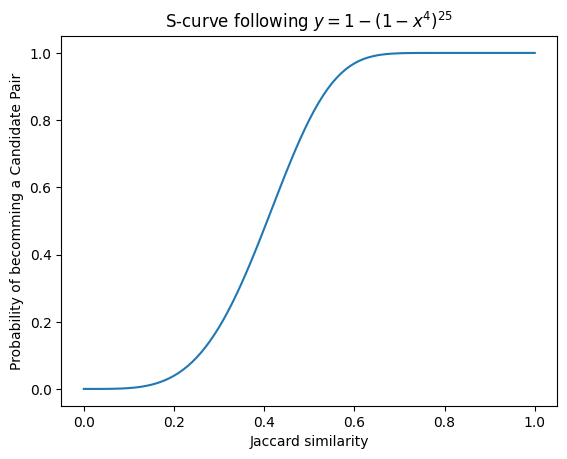

s=0.0  -->  1-(1-s^r)^b = 0.0
s=0.1  -->  1-(1-s^r)^b = 0.0024970022987352847
s=0.2  -->  1-(1-s^r)^b = 0.03924133845111111
s=0.3  -->  1-(1-s^r)^b = 0.18398666378816453
s=0.4  -->  1-(1-s^r)^b = 0.4770840580390957
s=0.5  -->  1-(1-s^r)^b = 0.8008034052167364
s=0.6  -->  1-(1-s^r)^b = 0.9688848385454178
s=0.7  -->  1-(1-s^r)^b = 0.9989554935822509
s=0.8  -->  1-(1-s^r)^b = 0.9999981004150488
s=0.9  -->  1-(1-s^r)^b = 0.9999999999974248
s=1.0  -->  1-(1-s^r)^b = 1.0


In [28]:
import numpy as np
import matplotlib.pyplot as plt

r = 4
b = 25

x = np.linspace(0,1,101)
y = 1 - (1 - x**r)**b

plt.plot(x,y)
plt.title('S-curve following $y = 1 - (1 - x^4)^{25}$')
plt.xlabel('Jaccard similarity')
plt.ylabel('Probability of becomming a Candidate Pair')
plt.show()

for i in range(11):
    print(f"s={i/10}  -->  1-(1-s^r)^b = {y[i*10]}") # Print probabilities for Jaccard similarities 0.1, 0.2, 0.3, ...

Here are a couple things to look at to analyze this graph:

1. Looking at this data, we see that a pair of columns has at least a 50% chance of becomming a candidate pair when the Jaccard similarity is a little over 0.4 or higher.
    * The probability jumps from 0.18 to 0.80 (a difference of over 0.6) when $s$ increases from 0.3 to 0.5. That means that the slope where the probability is 50% ($s$ is just over 0.4) is roughly $0.6/0.2 = 3$.
    * This shows a pretty clear distinction between the two sides of the graph
    * If two columns are not similar, then there is little chance that bands will agree, so little chance it will become a candidate pair
    * If two columns are actually similar, then there is a high chance that bands will agree, so high chance it will become a candidate pair

2. At $s=0.7$, we calculate the chance of one band not agreeing to be $1-0.7^4 = 0.7599$ (That is, a 75.99% chance of at least one disagreement in a band, or only a 24.01% chance that all agree). However, if we look at all 25 rows, then there is a $(1-0.7^4)^{25} = 0.0010$ (or $0.1\%$) chance that all bands disagree (that is, of the 25 bands, the one you look at has a 99.9% chance that the signatures agree).

So, LSH actually does significantly increase the odds of finding columns with high Jaccard similarity.

-----
## Project
* Using a dataset on food types consumed in different countries, find the food types that are most similar and the countries that consume those food types.
  
## Homework
1. Exercise 3.1.1
2. Exercise 3.1.2
3. Exercise 3.2.1
4. Exercise 3.2.2
5. Exercise 3.3.1
6. Exercise 3.3.3
7. Exercise 3.3.4
8. Exercise 3.3.8
9. Exercise 3.4.1
10. Exercise 3.4.2
11. Exercise 3.5.1
12. Exercise 3.5.2
13. Exercise 3.5.4
14. Exercise 3.5.5